# Wind Energy Forecaseting

The goal of this notebook is to perform the energy forecasting for the ["Global Energy Forecasting Competition 2012" ](https://www.kaggle.com/c/GEF2012-wind-forecasting).

"This competition is deveoped to mimic the operation 48-hour ahead prediction of hourly power generation. This is performed for 7 wind farms. The data being used for this competition are historical measurements and additional wind forecast information (48-hour ahead predictions of wind speed and direction at the sites). The data is available for period ranging from the 1st hour of 2009/7/1 to the 12th hour of 2012/6/28." [ref](https://www.kaggle.com/c/GEF2012-wind-forecasting)


### Package Import

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
sns.set(style='whitegrid', context='notebook')

### Data Import and Organizing

We are going to first import the energy dataset. It will read the train dataset and generate the following columns:

- datetime index
- wind power
- hour
- month
- year
- farm number

It is noted that this dataset contains historical data for each wind farm for each 

In [2]:
energy = pd.read_csv('train.csv')

energy['hour'] = energy['date'].apply(lambda x: str(x)[-2:]) # extracting hour
energy['month'] = energy['date'].apply(lambda x: str(x)[4:6]) # extracting month
energy['year'] = energy['date'].apply(lambda x: str(x)[:4]) # extracting year
energy.date = pd.to_datetime(energy.date, format='%Y%m%d%H', errors='ignore')


energy = pd.melt(frame = energy, id_vars =['date','hour','month', 'year'] ,value_vars =['wp1','wp2','wp3','wp4','wp5','wp6','wp7'], var_name = 'farm', value_name='power' )
energy.farm = energy.farm.apply(lambda x: int(x[2:]))
energy.set_index('date', inplace=True) # we generate a datetime series from the data

In [3]:
energy.describe()

,farm,power
count,131299.000000,131299.000000
mean,4.000000,0.284145
std,2.000008,0.289788
min,1.000000,0.000000
25%,2.000000,0.040000
50%,4.000000,0.178000
75%,6.000000,0.455000
max,7.000000,0.992000


In [4]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131299 entries, 2009-07-01 00:00:00 to 2012-06-26 12:00:00
Data columns (total 5 columns):
hour     131299 non-null object
month    131299 non-null object
year     131299 non-null object
farm     131299 non-null int64
power    131299 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 6.0+ MB


The following demonstrates the mean power generation over several years for all farms.

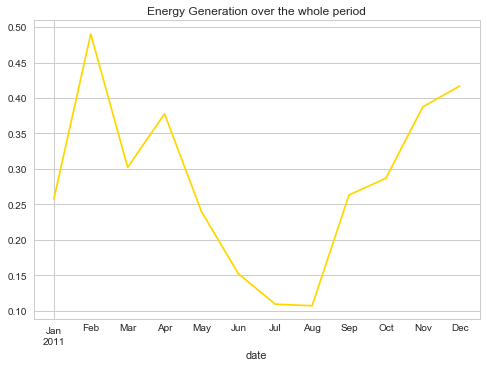

In [5]:
# Let's see how the energy over a year
energy.loc['2011', 'power'].resample('M').mean().plot(title = 'Energy Generation over the whole period' , color = 'gold')
plt.show()

## Forecast data

For each farm, one CSV file is provided that contains 48 hours forecasting of wind speed and wind direction.

First let's get the datetime of the prediction, and the actual time and also the farm number into the data set.

In [6]:
pattern = 'windforecasts*.csv'
csv_files = glob.glob(pattern) # allows importing file name for wild cards
forecast = list()
for indx, file in enumerate(csv_files):
    temp_df = pd.read_csv(file)
    temp_df ['farm'] = indx + 1
    temp_df['date'] = pd.to_datetime(temp_df.date, format='%Y%m%d%H')
    temp_df.rename(columns = {'date':'start', 'hors':'dist'}, inplace= True)
    temp_df['date'] = temp_df.start + pd.to_timedelta(temp_df.dist, unit='h')
    temp_df.set_index('date', inplace=True)
    forecast.append(temp_df)

Now, we will concatanate the dataframes.

In [7]:
single_forecast = pd.concat(forecast)
single_forecast.head()

,start,dist,u,v,ws,wd,farm
date,,,,,,,
2009-07-01 01:00:00,2009-07-01,1,2.34,-0.79,2.47,108.68,1
2009-07-01 02:00:00,2009-07-01,2,2.18,-0.99,2.40,114.31,1
2009-07-01 03:00:00,2009-07-01,3,2.20,-1.21,2.51,118.71,1
2009-07-01 04:00:00,2009-07-01,4,2.35,-1.40,2.73,120.86,1
2009-07-01 05:00:00,2009-07-01,5,2.53,-1.47,2.93,120.13,1


### Joining Energy and Forecast Datasets

We will join the two data sets and look at their correlations and perform some EDA on data.

In [8]:
whole_data = pd.merge(single_forecast.reset_index(), energy.reset_index(),
                      how = 'left', on = ['date','farm'])
whole_data.describe()

,dist,u,v,ws,wd,farm,power
count,733824.000000,655704.000000,655704.000000,655704.000000,655704.000000,733824.000000,524664.000000
mean,24.500000,1.162191,-0.052091,4.616505,155.373093,4.000000,0.284399
std,13.853409,3.378194,3.720165,2.300665,100.380787,2.000001,0.289817
min,1.000000,-14.600000,-15.360000,0.010000,0.000000,1.000000,0.000000
25%,12.750000,-1.180000,-2.760000,2.950000,71.800000,2.000000,0.040000
50%,24.500000,1.260000,-0.160000,4.220000,140.650000,4.000000,0.178000
75%,36.250000,3.330000,2.630000,5.920000,226.540000,6.000000,0.455000
max,48.000000,16.780000,16.640000,16.960000,360.000000,7.000000,0.992000


C:\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


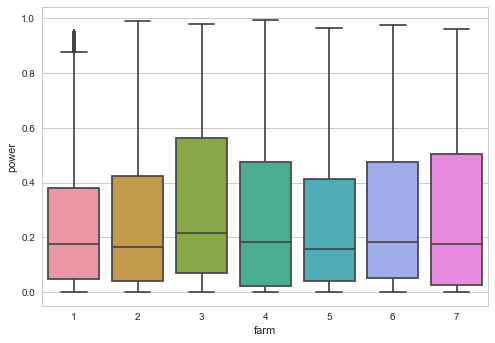

In [9]:
sns.boxplot(x="farm", y="power", data= whole_data.dropna())
plt.show()

Different farms seem to have different average wind powers.

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


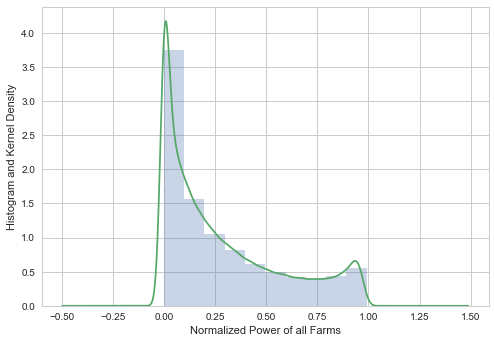

In [10]:
plt.hist(whole_data.dropna().power, normed = True, alpha = 0.3)
whole_data.dropna().power.plot.kde()
plt.xlabel('Normalized Power of all Farms')
plt.ylabel('Histogram and Kernel Density')
plt.show()

It is clear that most of the time wind turbines are not working around their rating. We can now check the relationship between wind speed and wind power.

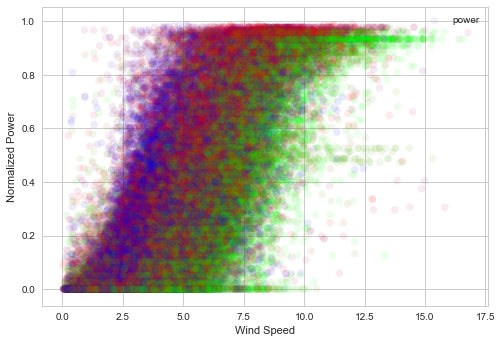

In [11]:
data = whole_data.dropna().sample(100000)
plt.scatter(data.ws, data.power, c = data.farm, cmap=plt.cm.brg, alpha = .08)
plt.xlabel('Wind Speed')
plt.ylabel('Normalized Power')
plt.legend()
plt.show()

There is an obvious relationship between wind speed and normalized power. Also there is an obvious difference between different farms.

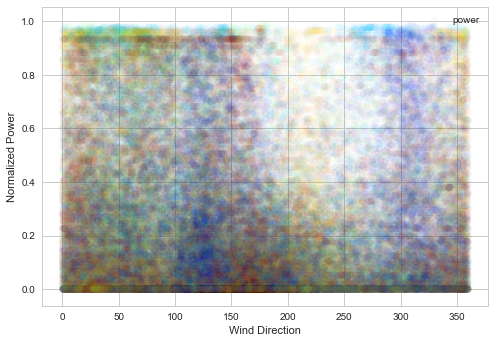

In [12]:
plt.scatter(data.wd, data.power, c = data.farm, cmap=plt.cm.jet, alpha = .024)
plt.xlabel('Wind Direction')
plt.ylabel('Normalized Power')
plt.legend()
plt.show()

We can vaguley see that each farm has a couple of dominant direction, which is intuitive. Each location will have some dominant wind. We might use this informaiton later in our feature engineering section. 

### Last day point

We want to see what is the profile of the power 24 hours or 48 hours before the prediction. This might carry some information about the power output of the next day exactly at the same time. For example, assume we are predicting power for tomorrow at 3:00pm from today at 10:00 pm. If we can go back 7 hours, we will have one day difference with the predicted value.

In [13]:
date_power = whole_data[['date','dist','power','farm']]

In [14]:
farm_date_power = whole_data[['date','farm','power']]

In [15]:
date_power['last_day'] = date_power.dist.apply(lambda x: 24 if 0<x<24 else 48)
date_power.head()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,dist,power,farm,last_day
0,2009-07-01 01:00:00,1,0.085,1,24
1,2009-07-01 02:00:00,2,0.020,1,24
2,2009-07-01 03:00:00,3,0.060,1,24
3,2009-07-01 04:00:00,4,0.045,1,24
4,2009-07-01 05:00:00,5,0.035,1,24


In [16]:
date_power['date_last_day'] = date_power.date - pd.to_timedelta(date_power['last_day'], unit='h')
date_power.head()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,dist,power,farm,last_day,date_last_day
0,2009-07-01 01:00:00,1,0.085,1,24,2009-06-30 01:00:00
1,2009-07-01 02:00:00,2,0.020,1,24,2009-06-30 02:00:00
2,2009-07-01 03:00:00,3,0.060,1,24,2009-06-30 03:00:00
3,2009-07-01 04:00:00,4,0.045,1,24,2009-06-30 04:00:00
4,2009-07-01 05:00:00,5,0.035,1,24,2009-06-30 05:00:00


In [17]:
date_power_1 = date_power.merge(farm_date_power, left_on =['date_last_day','farm'], right_on =['date','farm'], how = 'left', suffixes=['','last_day'] )
date_power_1.iloc[10000:10004]

,date,dist,power,farm,last_day,date_last_day,datelast_day,powerlast_day
10000,2009-07-29 12:00:00,36,0.256,1,48,2009-07-27 12:00:00,2009-07-27 12:00:00,0.10
10001,2009-07-29 12:00:00,36,0.256,1,48,2009-07-27 12:00:00,2009-07-27 12:00:00,0.10
10002,2009-07-29 13:00:00,37,0.090,1,48,2009-07-27 13:00:00,2009-07-27 13:00:00,0.16
10003,2009-07-29 13:00:00,37,0.090,1,48,2009-07-27 13:00:00,2009-07-27 13:00:00,0.16


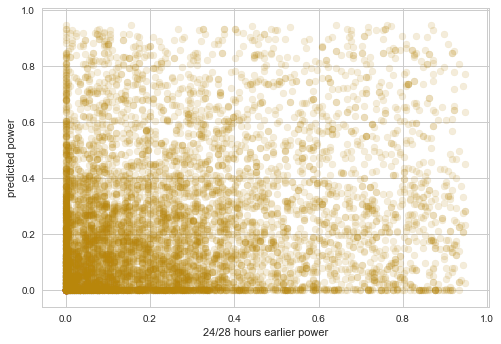

In [18]:
date_power_1_sample = date_power_1.sample(100000)
plt.scatter(date_power_1_sample.loc[date_power_1_sample.farm==1].powerlast_day,
            date_power_1_sample.loc[date_power_1_sample.farm==1].power, color = 'darkgoldenrod',
           alpha = 0.15)
plt.xlabel('24/28 hours earlier power')
plt.ylabel('predicted power')
plt.show()

In [19]:
date_power_1.loc[date_power_1.farm==1].powerlast_day.corr(date_power_1.loc[date_power_1.farm==1].power)

0.19898164793229473

### Last three hours profile

We want to see what is the profile of the power for the last 3 hours before each prediction. We like to get the moving average of the previous 3 hours power at the point of prediction. We will see that around $10\%$ of the variance is explained through this variable which makes it acceptable to be included in the feature_set.

In [20]:
power_each_farm = pd.read_csv('train.csv') #getting the power for each farm
power_each_farm.date = pd.to_datetime(power_each_farm.date, format='%Y%m%d%H', errors='ignore')
power_each_farm.set_index('date', inplace=True)
power_each_farm_smoothed = power_each_farm.rolling(window=3).mean()
power_each_farm_smoothed.fillna(method='bfill',inplace=True)

In [21]:
profile_power = pd.melt(frame = power_each_farm_smoothed.reset_index(), id_vars =['date'] ,value_vars =['wp1','wp2','wp3','wp4','wp5','wp6','wp7'], var_name = 'farm', value_name='power_profile' )
profile_power.farm = profile_power.farm.apply(lambda x: int(x[2:]))

In [22]:
profile_power.rename(columns={"date": "start"},inplace=True)
profile_power.head()

,start,farm,power_profile
0,2009-07-01 00:00:00,1,0.050000
1,2009-07-01 01:00:00,1,0.050000
2,2009-07-01 02:00:00,1,0.050000
3,2009-07-01 03:00:00,1,0.055000
4,2009-07-01 04:00:00,1,0.041667


In [23]:
whole_data = whole_data.merge(profile_power, how='left', left_on = ['start','farm'], right_on = ['start','farm'])

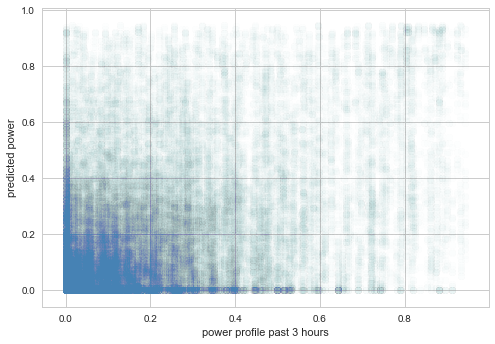

In [24]:
plt.scatter(whole_data.loc[whole_data.farm==1].power_profile,
            whole_data.loc[whole_data.farm==1].power, color = 'steelblue',
           alpha = 0.0075)
plt.xlabel('power profile past 3 hours')
plt.ylabel('predicted power')
plt.show()

In [25]:
whole_data.loc[whole_data.farm==1].power_profile.corr(whole_data.loc[whole_data.farm==1].power)

0.3405988748811246

Let's also include the last day feature to our feature set.

In [26]:
whole_data = whole_data.merge(date_power_1[['date','farm','powerlast_day']], on = ['date','farm'], how='left')
whole_data.iloc[1000:1004]

,date,start,dist,u,v,ws,wd,farm,hour,month,year,power,power_profile,powerlast_day
1000,2009-07-03 23:00:00,2009-07-02 12:00:00,35,5.84,-2.89,6.52,116.35,1,23,07,2009,0.476,0.013333,0.08
1001,2009-07-03 23:00:00,2009-07-02 12:00:00,35,5.84,-2.89,6.52,116.35,1,23,07,2009,0.476,0.013333,0.08
1002,2009-07-03 23:00:00,2009-07-02 12:00:00,35,5.84,-2.89,6.52,116.35,1,23,07,2009,0.476,0.013333,0.08
1003,2009-07-03 23:00:00,2009-07-02 12:00:00,35,5.84,-2.89,6.52,116.35,1,23,07,2009,0.476,0.013333,0.08


### EDA on wind speed and wind direction:

Before finalizing the train/test set, let's take a look at the information we might bea belt to get from the wind speed/wind direction.

In [27]:
wind_list = ['date','dist', 'u','v','ws','wd','farm', 'power']
wind = whole_data[wind_list]
wind = wind.sample(10000)
wind.head()

,date,dist,u,v,ws,wd,farm,power
8811206,2010-04-14 21:00:00,45,1.62,2.63,3.09,31.61,6,0.237
5180113,2009-10-12 04:00:00,4,2.03,1.29,2.40,57.42,4,0.000
2065502,2010-03-14 22:00:00,34,-0.61,-3.13,3.19,191.06,2,0.175
1996478,2010-01-29 04:00:00,40,-2.47,-3.29,4.11,216.91,2,0.016
8720670,2010-02-13 14:00:00,2,1.42,-3.40,3.69,157.38,6,0.000


We know that the zonal(``u``) and meridional(``v``) components are directly connected to the wind speed (``ws``) and wind direction (``wd``). Let's study that and see if we can potentially drop a few redundunt features.. 

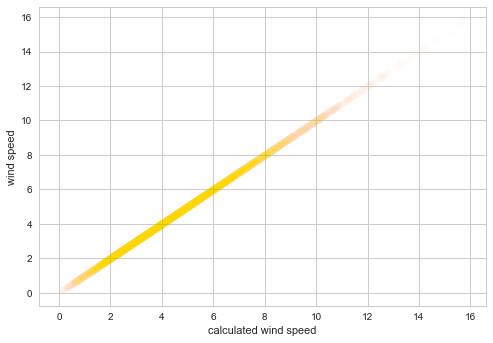

In [28]:
wind['calculated_ws'] = np.sqrt(wind.u**2+wind.v**2)
plt.scatter(wind.calculated_ws, wind.ws, alpha= 0.009, color = 'gold')
plt.xlabel('calculated wind speed')
plt.ylabel('wind speed')
plt.show()

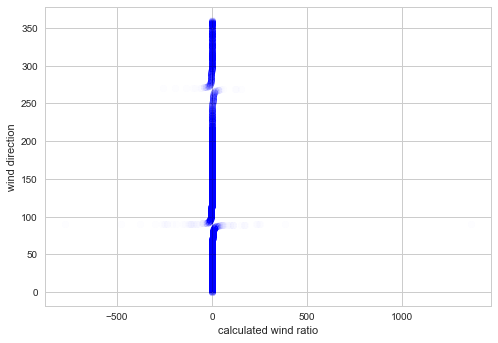

In [29]:
wind['calculated_ratio'] = (wind.u/wind.v)
plt.scatter(wind.calculated_ratio, wind.wd, alpha= 0.009, color = 'blue')
plt.xlabel('calculated wind ratio')
plt.ylabel('wind direction')
plt.show()

We see a tangetic relationship between calculated ratio and wind direction. Therefore, these two set of data (``ws, wd`` and ``u, v``) are redundunt. We need to see which one provides more information.

In [30]:
data_sample = wind.sample(3000)

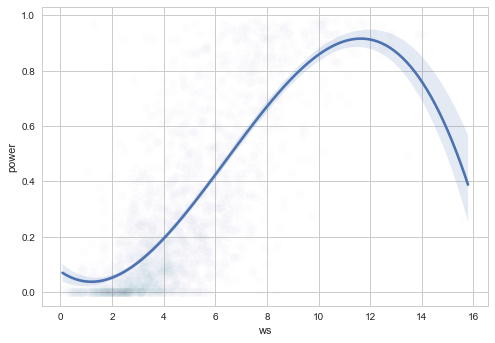

In [31]:
sns.regplot(x="ws", y="power", data=data_sample,
scatter_kws={"s": 80, "alpha":0.009},order=3,truncate=True)
plt.show()

We know that wind speed has a third order relationship with wind power generated from the wind farms.
This is also evident from the above relationship. Let's create a feature from cube of wind speed and wind power.

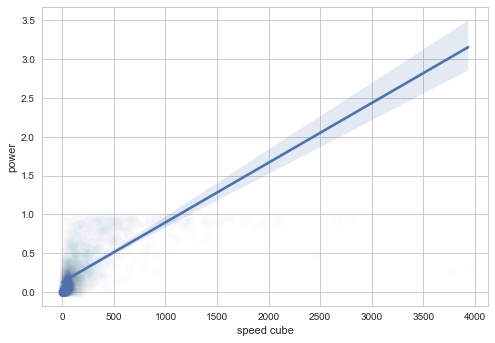

In [32]:
data_sample['speed_cube'] = data_sample['ws']**3
sns.regplot(x="speed_cube", y="power", data=data_sample,
scatter_kws={"s": 80, "alpha":0.009},truncate=True, robust=True)
plt.xlabel('speed cube')
plt.ylabel('power')
plt.show()

In [33]:
data_sample.speed_cube.corr(data_sample.power)**2

0.3831624993349083

We see that $43\%$ of the variance is explained by wind speed cube. This is very good. Another observation is that the wind turbine has some limitations, and even in very high speed, it might no generate more than its rating power. Moreover, the correlation has low uncertainty below 10m/s. For that, lets create a new feature (below_10) to capture this uncertainty.

Another observation is that sometimes in smaller speeds, the 

In [34]:
data_sample['below_10'] = data_sample.ws < 10

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


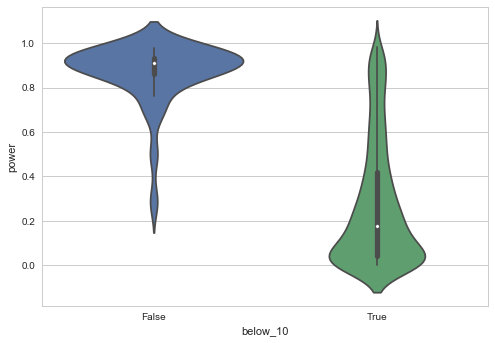

In [35]:
sns.violinplot(x="below_10", y="power", data=data_sample)
plt.show()

They are visually from different populations and we can use them in our classification. However, if we are using tree based regressors, there is not need for such categorization.

Another observation from power/speed_cube figure is that for some lower speed (<8m/s), the generated power reaches the rating power (0.8<power<1). This might be the results of forecasting error, or the wind direction. Let's get a boolean mask from this data and check the wind direction to see if it eefects it.

In [36]:
data_sample['high_power'] = (data_sample.ws<7) & (0.9<data_sample.power) & (data_sample.farm ==2)

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


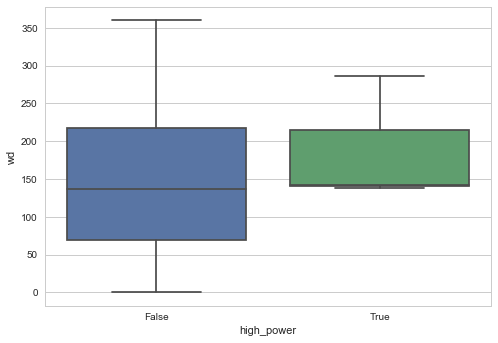

In [37]:
sns.boxplot(x="high_power", y="wd", data=data_sample.dropna())
plt.show()

We can further visualize the effect of wind direction, by keeping the wind speed almost constant and see the effect of wind direction on power. Before that, we need to visualize what wind speeds are dominant in each location. 

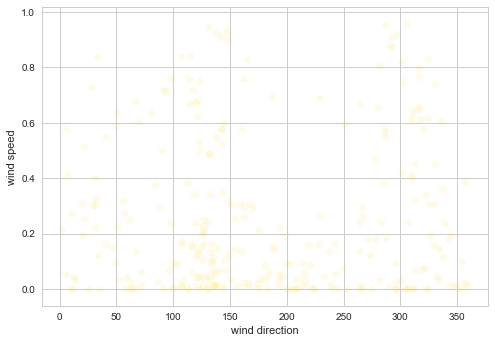

In [38]:
BM_const_power = (data_sample.farm ==2)
data_cons_power = data_sample.loc[BM_const_power,['wd','power']]
plt.scatter(data_cons_power.wd, data_cons_power.power, color='gold',alpha=0.08)
plt.xlabel('wind direction')
plt.ylabel('wind speed')
plt.show()

There seems to be three dominant wind directions, one around 20 degrees, the other around 120 decrees and last one aroun 330 degrees. Let's see, if we keep the effect of wind speed close to constant, how wind direction effect the wind power.From the figure we can see that in general, the wind direction of 330 degrees is stronger than the other two dominant speeds.

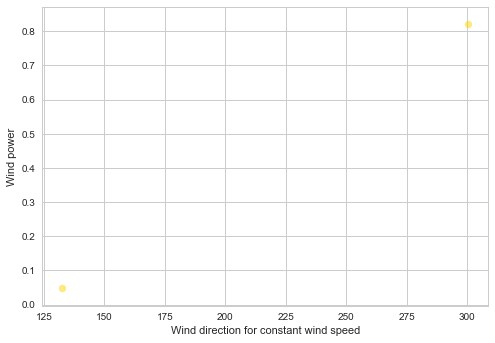

In [39]:
BM_const_power = (data_sample.farm ==2) &(data_sample.ws<7) &(data_sample.ws>6.8)
data_cons_power = data_sample.loc[BM_const_power,['wd','power']]
plt.scatter(data_cons_power.wd, data_cons_power.power, color='gold',alpha=0.5)
plt.xlabel('Wind direction for constant wind speed')
plt.ylabel('Wind power')
plt.show()

The wind direction has an obvios relationship with whether the power is too high. Therefore, we can exclude such information. For that, we need to get the median of the wind direction for each farm and calculated the difference away from that value. Another point, is that foreach farm, this value is differet (as probably each farm is located in different direction).

In [40]:
def angle_diff(angle):
    angle = angle % 360
    if angle <180:
        return angle
    else:
        return angle-180

In [41]:
farm_dominant = dict()

for farm in range(1,8):
    boolean_mask = (data_sample.ws<7) & (0.9<data_sample.power) & (data_sample.farm ==farm)
    series = data_sample.loc[boolean_mask].wd
    farm_dominant[farm]= series.median()

print(farm_dominant)

{1: 58.33, 2: 142.3, 3: 108.17, 4: 337.75, 5: 40.7, 6: 128.745, 7: 68.57}


In [42]:
data_sample['angle_diff'] = (data_sample.farm.replace(farm_dominant)-data_sample.wd).apply(angle_diff)

In [43]:
data_sample.head()

,date,dist,u,v,ws,wd,farm,power,calculated_ws,calculated_ratio,speed_cube,below_10,high_power,angle_diff
5504483,2010-05-11 21:00:00,21,-8.08,2.93,8.59,289.93,4,0.887,8.594841,-2.757679,633.839779,True,False,47.820
6756199,2009-08-09 22:00:00,34,2.18,4.91,5.37,23.93,5,0.116,5.372197,0.443992,154.854153,True,False,16.770
4451727,2011-06-20 10:00:00,10,-2.81,-1.19,3.06,247.04,3,0.049,3.051590,2.361345,28.652616,True,False,41.130
7140255,2010-04-17 01:00:00,37,5.09,-0.30,5.10,93.31,5,0.728,5.098833,-16.966667,132.651000,True,False,127.390
8786878,2010-03-29 00:00:00,12,-2.02,-1.04,2.28,242.84,6,0.092,2.272004,1.942308,11.852352,True,False,65.905


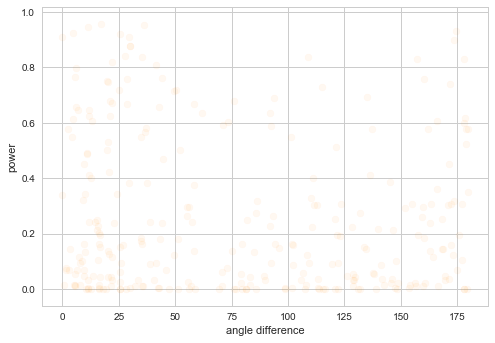

In [44]:
plt.scatter(data_sample.loc[data_sample.farm==2,'angle_diff' ],data_sample.loc[data_sample.farm==2,'power' ], color='darkorange',alpha=0.055)
plt.xlabel('angle difference')
plt.ylabel('power')
plt.show()

In [45]:
data_sample.loc[data_sample.farm==2,'angle_diff' ].corr(data_sample.loc[data_sample.farm==2,'power' ])

-0.10598750765426673

After this calculation, we see that not a lot information is available inside wind direction. We wil put our focus on wind speed, its square, and its cube.

### Feature cleaning, scaling, and data modelling:

After doing a thorough analysis of the data and extracting meaningful features, let's clean the model and train a regressor.

In [46]:
whole_data.columns.values

array(['date', 'start', 'dist', 'u', 'v', 'ws', 'wd', 'farm', 'hour',
       'month', 'year', 'power', 'power_profile', 'powerlast_day'],
      dtype=object)

In [47]:
whole_data['ws2']= whole_data.ws ** 2
whole_data['ws3'] = whole_data.ws ** 3
whole_data.columns.values

array(['date', 'start', 'dist', 'u', 'v', 'ws', 'wd', 'farm', 'hour',
       'month', 'year', 'power', 'power_profile', 'powerlast_day', 'ws2',
       'ws3'], dtype=object)

In [48]:
whole_data = whole_data.drop(axis = 1, columns = ['date','start','u','v'])
whole_data.head()

,dist,ws,wd,farm,hour,month,year,power,power_profile,powerlast_day,ws2,ws3
0,1,2.47,108.68,1,01,07,2009,0.085,0.05,NaN,6.1009,15.069223
1,2,2.40,114.31,1,02,07,2009,0.020,0.05,NaN,5.7600,13.824000
2,3,2.51,118.71,1,03,07,2009,0.060,0.05,NaN,6.3001,15.813251
3,4,2.73,120.86,1,04,07,2009,0.045,0.05,NaN,7.4529,20.346417
4,5,2.93,120.13,1,05,07,2009,0.035,0.05,NaN,8.5849,25.153757


In [49]:
data = whole_data.loc[~whole_data.power.isnull(),:]
hold_out = whole_data.loc[whole_data.power.isnull(),:].drop(axis=1, columns='power')
print("Hold out size is {:.2f} of the training dataset".format(hold_out.shape[0]/data.shape[0]))

Hold out size is 0.40 of the training dataset


In [50]:
data.dropna(inplace=True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Train test split

In [51]:
y = data.power
X = data.drop(axis=1, columns = 'power')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [52]:
neigh = KNeighborsRegressor()
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [53]:
print("Train R^2 is {}".format(neigh.score(X_train, y_train)))
print("Test R^2 is {}".format(neigh.score(X_test,y_test)))

Train R^2 is 0.9995484565059078
Test R^2 is 0.9986014944779987


The model shows remarkable accuracy. Let's further prove that using k-fold cross validation.

In [54]:
negh2 = KNeighborsRegressor()
scoring = ['explained_variance','r2', 'neg_mean_squared_error']
cv_results = cross_val_score(negh2, X, y, cv=5,scoring = 'explained_variance')
print(cv_results)

[0.12390445 0.35396235 0.37766853 0.3149979  0.41159974]


In [55]:
cv_results = cross_val_score(negh2, X, y, cv=5,scoring = 'r2')
print(cv_results)

[0.11519222 0.34608359 0.37588289 0.31455648 0.35841067]


In [56]:
print(np.mean(cv_results))

0.3020251711880323


Using the available data sets, up to 33% of the total variance in the output power is explanied.
We need more information for explaining the rest of the variance.

We now would like to perform standard sacaler and see if there will be improvement in our cross validation score. The reason is that the non-tree base techniques (such as KNN, ANN, linear regression) calclate some form of distance which emphasizes features with larger scales. For scaler, we use DataFramMapper from sklearn_pandas package. This allows for recieving dataframe aftare scalation.

In [57]:
mapper = DataFrameMapper([(X.columns, StandardScaler())])
scaled_features = mapper.fit_transform(X.copy(), 4)
scaled_X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [58]:
print(scaled_X.head())
print(scaled_X.shape)
print(X.shape)

        dist        ws        wd  farm      hour     month      year  \
37  0.065161 -1.240061  0.019384  -1.5 -1.518572 -0.137888 -1.298134   
38  0.065161 -1.240061  0.019384  -1.5 -1.518572 -0.137888 -1.298134   
40  0.137346 -1.352828  0.140297  -1.5 -1.374074 -0.137888 -1.298134   
41  0.137346 -1.352828  0.140297  -1.5 -1.374074 -0.137888 -1.298134   
43  0.209531 -1.426561  0.249301  -1.5 -1.229575 -0.137888 -1.298134   

    power_profile  powerlast_day       ws2       ws3  
37      -0.809876      -0.672037 -0.866735 -0.590828  
38      -0.809876      -0.672037 -0.866735 -0.590828  
40      -0.809876      -0.901749 -0.897924 -0.597732  
41      -0.809876      -0.901749 -0.897924 -0.597732  
43      -0.809876      -0.760388 -0.915627 -0.601130  
(6077911, 11)
(6077911, 11)


In [59]:
negh3 = KNeighborsRegressor()
cv_results_scaled = cross_val_score(negh3, scaled_X, y, cv=3,scoring = 'r2')
print(cv_results_scaled)

[0.23243113 0.43476867 0.35213399]


In [60]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
cv_results_random = cross_val_score(regr, scaled_X, y, cv=3,scoring = 'r2')
print(cv_results_random)

[0.42244716 0.56318644 0.5322061 ]


In [63]:
print("R^2 score for un-scaled K-NN is: {}".format(cv_results.mean()))
print("R^2 score for scaled K-NN is: {}".format(cv_results_scaled.mean()))
print("R^2 score for scaled random forest is: {}".format(cv_results_random.mean()))

R^2 score for un-scaled K-NN is: 0.3020251711880323
R^2 score for scaled K-NN is: 0.33977792844363064
R^2 score for scaled random forest is: 0.5059465659403787


I decreased the number of cross validation folds as the code speed decreases as the number of folds increases.

## Conclusion

The results shows that moving from a regular KNN to scaled version largely improves the regressoion quality. Moreover, random forest regressor demonstrates better prediction. We ended up explaining $50\%$ of the variance using the available data.